In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import shutil
from os.path import join as pjoin
from mpl_toolkits.mplot3d import axes3d
import matplotlib
from matplotlib import style
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import math
import pandas as pd
import numba
from numba import jit
from tqdm import tqdm
import time

In [7]:
def import_file(namefile, delimiter, start_column):
    """
    Imports data from a text file.

    Reads a file line by line, splits each line by the specified delimiter,
    and converts the elements from 'start_column' onwards into floats.
    It skips empty lines.

    Args:
        namefile (str): The path to the input file.
        delimiter (str): The delimiter string used to separate values.
        start_column (int): The 0-based index of the column from which 
                            to start reading data.

    Returns:
        list: A nested list where each inner list contains the
              float-converted data from a single line.
    """
    with open(namefile, 'r') as file:
        file_lines = file.readlines()
    
    data_list = []
    for line in file_lines:
        if line.strip():  # Avoid empty lines
            temp_list = line.strip().split(delimiter)
            data_list.append([float(i) for i in temp_list[start_column::]])
    return data_list

def firingRate_by_trial(spikes, t_start=-2, t_end=8, window_size=0.05, step_size=0.01, **kwargs):
    """
    Calculates firing rate per trial using a sliding window.

    This function processes a 2D spike array, where spikes are grouped
    by trial. It calculates the firing rate for each trial individually.
    Assumes `spikes` array format: [trial_id, spike_time, ..., class_id].

    Args:
        spikes (np.ndarray): A 2D array, [trial_id, spike_time, ..., class_id].
        t_start (float, optional): The start time for the analysis. Defaults to -2.
        t_end (float, optional): The end time for the analysis. Defaults to 8.
        window_size (float, optional): The duration of the sliding window. Defaults to 0.05.
        step_size (float, optional): The amount to slide the window forward. Defaults to 0.01.

    Returns:
        tuple:
            - np.ndarray: A 2D array (num_trials x num_bins) of firing rates.
            - np.ndarray: A 1D array (num_trials) of the class ID for each trial.
            - np.ndarray: A 1D array (num_bins) of the time vector.
    """
    trials = np.unique(spikes[:, 0])
    trial_classes = np.zeros(len(trials))
    
    num_bins = int(np.floor(((t_end - t_start) / step_size) - (window_size / step_size)) + 1)
    rate_matrix = np.zeros((len(trials), num_bins), dtype=np.float32)
    time_vector = np.zeros(num_bins)
    
    for i, trial_id in enumerate(trials):
        indices = np.where(spikes[:, 0] == trial_id)[0]
        col_index = 0
        current_time_window_start = t_start
        trial_classes[i] = spikes[indices[0], -1]
        
        while current_time_window_start + window_size <= t_end:
            rate_matrix[i, col_index] = (np.sum((spikes[indices, 1] >= current_time_window_start) * ((spikes[indices, 1] < (current_time_window_start + window_size)))))
            current_time_window_start = current_time_window_start + step_size
            if i == 0:
                time_vector[col_index] = current_time_window_start + window_size
            col_index += 1
            
    return rate_matrix / window_size, trial_classes, time_vector

In [8]:
def firingRate(spike_times, t_start=-8, t_end=10, window_size=0.2, step_size=0.05, **kwargs):
    """
    Calculates the firing rate over time using a sliding window for a single trial.

    This JIT-compiled function counts spikes within a sliding window
    to compute the firing rate (in spikes/second).

    Args:
        spike_times (np.ndarray): A 1D array of spike times.
        t_start (float, optional): The start time for the analysis. Defaults to -8.
        t_end (float, optional): The end time for the analysis. Defaults to 10.
        window_size (float, optional): The duration of the sliding window (e.g., 0.2s).
                                       Defaults to 0.2.
        step_size (float, optional): The amount to slide the window forward in each
                                     step. Defaults to 0.05.

    Returns:
        tuple:
            - np.ndarray: A 2D array (shape 1xN) containing the firing rate
                          (spikes/sec) for each time bin.
            - np.ndarray: A 1D array (shape Nx1) containing the center time
                          for each corresponding bin.
    """
    num_bins = int(np.floor(((t_end - t_start) / step_size) - (window_size / step_size))) + 1
    spike_counts = np.zeros((1, num_bins), dtype=np.float32)
    time_vector = np.zeros(num_bins)
    col_index = 0
    current_time_window_start = t_start
    
    while current_time_window_start + window_size <= t_end:
        spike_counts[0, col_index] = (np.sum((spike_times >= current_time_window_start) * (spike_times < (current_time_window_start + window_size))))
        current_time_window_start = current_time_window_start + step_size
        
        time_vector[col_index] = current_time_window_start + window_size - step_size
        col_index += 1
        
    return spike_counts / window_size, time_vector

Alignment Menu: 

1: Start of first stimulus
2: End of first stimulus
3: Start of second stimulus
4: End of second stimulus
Press the selection key 2


  0%|          | 0/2 [00:00<?, ?it/s]

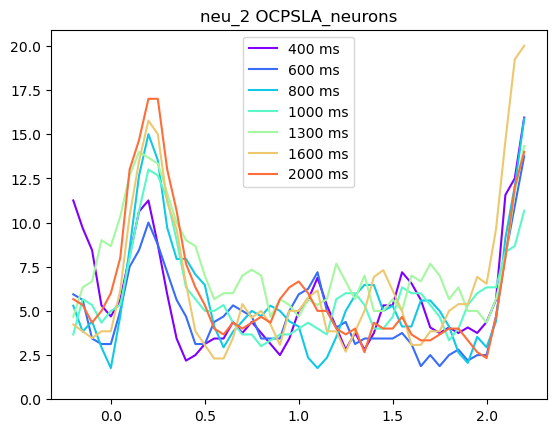

 50%|█████     | 1/2 [00:00<00:00,  1.84it/s]

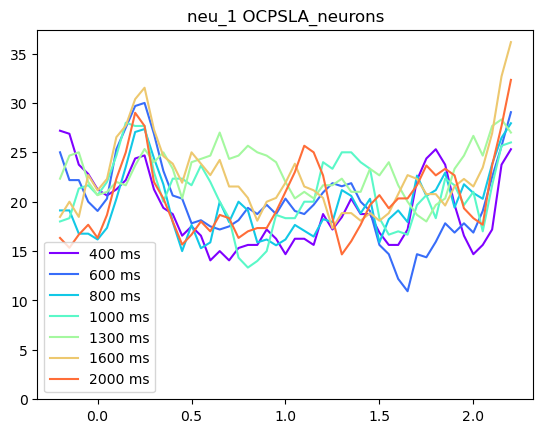

100%|██████████| 2/2 [00:01<00:00,  1.88it/s]


In [16]:
search_folder = "D:\\Neural recordings for spike sorting with UMAP and PCA\\Figure S4\\Session"
set_type = "OCPSLA"
labeled_neuron_directory = os.listdir(search_folder)

while(True):
    
    print("Alignment Menu: \n")
    print("1: Start of first stimulus")
    print("2: End of first stimulus")
    print("3: Start of second stimulus")
    print("4: End of second stimulus")
    
    alignment_choice = int(input("Press the selection key "))
    
    if alignment_choice in range(1, 5):
        break
    else:
        print("Incorrect selection")
neuron_firing_rates = []    
neuron_classes = []

for folder_name in labeled_neuron_directory:
    if set_type in folder_name:
        set_to_use = pjoin(search_folder, folder_name)
        neurons = os.listdir(set_to_use)
        neuron_index = -1
        
        neuron_indices = [-1, -2]
        selected_neurons = [neurons[i] for i in neuron_indices]
        
        for neuron_filename in tqdm(selected_neurons):
            if neuron_filename.find("neu") != -1 and neuron_filename.find(".csv") and neuron_filename.find("._") == -1:
                behavioral_data = np.loadtxt(pjoin(search_folder, folder_name, neuron_filename), delimiter=",", usecols=range(31))
                correct_trials = np.nonzero(behavioral_data[:, 4] == 1)[0]
                
                behavioral_data_correct = behavioral_data[correct_trials, :]
                
                if len(behavioral_data_correct) < 70:
                     continue
                
                classes, valid_trials = np.unique(behavioral_data_correct[:, 1], return_counts=True)
                classes = np.int32(classes)
                
                if len(classes) == 0:
                    continue
                
                if len(valid_trials) < 5:
                    continue
                
                if len(classes) != 14:
                    continue
                
                neuron_spike_file_data = import_file(pjoin(search_folder, folder_name, neuron_filename), ",", 31)
                neuron_spikes_correct = [neuron_spike_file_data[i] for i in correct_trials]
                
                neuron_index += 1
                
                neuron_rates_by_class = []
                
                neuron_classes.append(classes)
                
                first_stimulation_period = [0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1, 1, 1.3, 1.3, 1.6, 1.6, 2, 2]
                second_stimulation_period = [2.2, 2.8, 2.2, 3, 2.4, 3.3, 2.6, 3.6, 2.8, 4, 3, 4.3, 3.3, 4.8]
                first_stimulus_period = [0.4, 0.6, 0.8, 1, 1.3, 1.6, 2]
                second_stimulus_period = [0.2, 0.8, 0.2, 1, 0.4, 1.3, 0.6, 1.6, 0.8, 2, 1, 2.3, 1.3, 2.8]
                delay_period = [1.2] * 14
                
                binary_analysis_vector = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
                
                aligned_spike_times = []
                
                for class_i in classes:
                    
                    trial_indices = np.nonzero(behavioral_data_correct[:, 1] == class_i)[0]
                    
                    temporal_rate_matrix = np.empty((len(trial_indices), 317))
                    
                    aligned_spike_times_class = []
                    aligned_spike_times.append(aligned_spike_times_class)
                    
                    for index, trial_i in enumerate(trial_indices):
                        
                        if alignment_choice == 1:
                            aligned_times_trial = neuron_spikes_correct[trial_i] - behavioral_data_correct[trial_i, 24] + behavioral_data_correct[trial_i, 25]
                            
                        if alignment_choice == 2:
                            aligned_times_trial = neuron_spikes_correct[trial_i] - behavioral_data_correct[trial_i, 25] + behavioral_data_correct[trial_i, 25]
                        if alignment_choice == 3:
                            aligned_times_trial = neuron_spikes_correct[trial_i] - behavioral_data_correct[trial_i, 26] + behavioral_data_correct[trial_i, 25]
                            
                        if alignment_choice == 4:
                            aligned_times_trial = neuron_spikes_correct[trial_i] - behavioral_data_correct[trial_i, 27] + behavioral_data_correct[trial_i, 25]
                            
                        aligned_spike_times_class.append(aligned_times_trial)
                        
                        temporal_rate_matrix[index, :], time_bins = firingRate(aligned_times_trial, t_start=-8, t_end=8, window_size=0.2, step_size=0.05)
                        
                    neuron_rates_by_class.append(temporal_rate_matrix)
                                        
                color_list = plt.get_cmap("rainbow")(np.linspace(0, 1, 8))
                
                interval_durations = ["400 ms", "600 ms", "800 ms", "1000 ms", "1300 ms", "1600 ms", "2000 ms"]
                
                neuron_rates_by_class_grouped = [np.vstack((neuron_rates_by_class[i], neuron_rates_by_class[i + 1])) for i in range(0, len(neuron_rates_by_class), 2)]
                
                for class_index in range(len(neuron_rates_by_class_grouped)):
                    current_class_rates = neuron_rates_by_class_grouped[class_index]
                    average_for_class = np.mean(current_class_rates, axis=0)
                    time_start_plot = -0.2
                    time_end_plot = 2.2
                    start_index = np.argmin(np.abs(time_bins - time_start_plot))
                    end_index = np.argmin(np.abs(time_bins - time_end_plot)) + 1
                    plt.plot(time_bins[start_index:end_index], average_for_class[start_index:end_index], color=color_list[class_index])
                    plt.legend(interval_durations)
                    
                plt.title(f"{neuron_filename[0:5]} {folder_name}")
                plt.ylim(0)
                
                plt.show()

Alignment Menu: 

1: Start of first stimulus
2: End of first stimulus
3: Start of second stimulus
4: End of second stimulus
Press the selection key 2
OCPSLA_neurons


  0%|          | 0/2 [00:00<?, ?it/s]

neu_2.csv


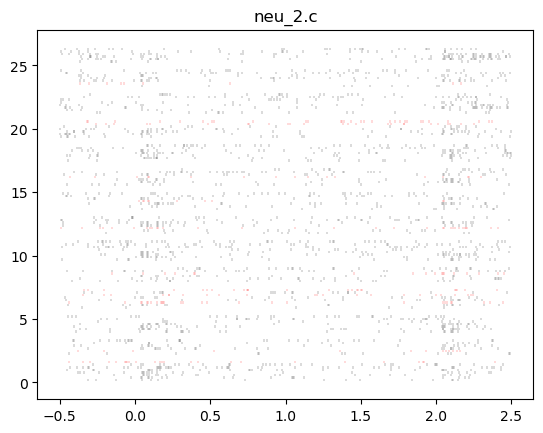

 50%|█████     | 1/2 [00:00<00:00,  1.51it/s]

neu_1.csv


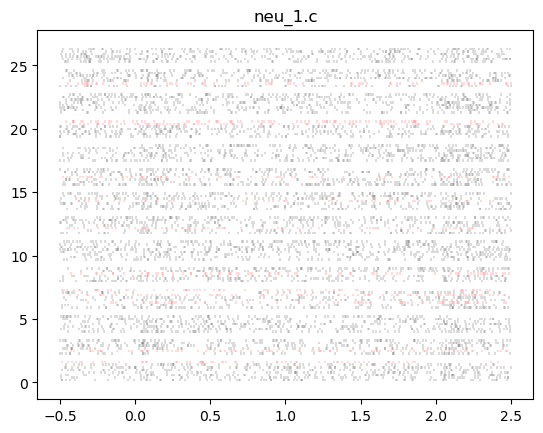

100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


In [18]:
search_folder = "D:\\Neural recordings for spike sorting with UMAP and PCA\\Figure S4\\Session"
set_type = "OCPSLA"
labeled_neuron_directory = os.listdir(search_folder)

while(True):
    
    print("Alignment Menu: \n")
    print("1: Start of first stimulus")
    print("2: End of first stimulus")
    print("3: Start of second stimulus")
    print("4: End of second stimulus")
    
    alignment_choice = int(input("Press the selection key "))
    
    if alignment_choice in range(1, 5):
        break
    else:
        print("Incorrect selection")
    
neuron_firing_rates = []    
neuron_mutual_information = []
neuron_moving_bumps = []
neuron_classes = []
neuron_information_dataframe = []
neuron_f_test_dataframe = []
neuron_f_tests = []
control_f_test_significance = []
total_performance = []
neuron_spikes = []

for folder_name in labeled_neuron_directory:
    
    if set_type in folder_name:
        
        print(folder_name)
        
        set_to_use = pjoin(search_folder, folder_name)
        neurons = os.listdir(set_to_use)
        
        neuron_index = -1
        
        spikes_per_neuron = []
        neuron_spikes.append(spikes_per_neuron)
        
        neuron_indices = [-1, -2]  
        selected_neurons = [neurons[i] for i in neuron_indices]
        
        for neuron_filename in tqdm(selected_neurons):
            if neuron_filename.find("neu") != -1 and neuron_filename.find(".csv") and neuron_filename.find("._") == -1:
                print(neuron_filename)
                
                behavioral_data = np.loadtxt(pjoin(search_folder, folder_name, neuron_filename), delimiter=",", usecols=range(31))
                
                if len(behavioral_data) < 70:
                    continue
                
                classes, valid_trials = np.unique(behavioral_data[:, 1], return_counts=True)
                classes = np.int32(classes)
                
                if len(classes) == 0:
                    continue
                
                if len(valid_trials) < 5:
                    continue
                
                if len(classes) != 14:
                    continue
                
                neuron_spike_file_data = import_file(pjoin(search_folder, folder_name, neuron_filename), ",", 31)
                
                neuron_index += 1
                
                neuron_rates_by_class = []
                neuron_firing_rates.append(neuron_rates_by_class)
                
                neuron_classes.append(classes)
                
                first_stimulation_period = [0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1, 1, 1.3, 1.3, 1.6, 1.6, 2, 2]
                second_stimulation_period = [2.2, 2.8, 2.2, 3, 2.4, 3.3, 2.6, 3.6, 2.8, 4, 3, 4.3, 3.3, 4.8]
                first_stimulus_period = [0.4, 0.6, 0.8, 1, 1.3, 1.6, 2]
                second_stimulus_period = [0.2, 0.8, 0.2, 1, 0.4, 1.3, 0.6, 1.6, 0.8, 2, 1, 2.3, 1.3, 2.8]
                delay_period = [1.2] * 14
                
                binary_analysis_vector = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
                
                aligned_spike_times = []
                spikes_per_neuron.append(aligned_spike_times)
                
                for class_i in classes:
                    
                    trial_indices = np.nonzero(behavioral_data[:, 1] == class_i)[0]
                    
                    temporal_rate_matrix = np.empty((len(trial_indices), 317))
                    
                    aligned_spike_times_class = []
                    aligned_spike_times.append(aligned_spike_times_class)
                    
                    for index, trial_i in enumerate(trial_indices):
                        
                        if alignment_choice == 1:
                            aligned_times_trial = neuron_spike_file_data[trial_i] - behavioral_data[trial_i, 24] + behavioral_data[trial_i, 25]
                            
                        if alignment_choice == 2:
                            aligned_times_trial = neuron_spike_file_data[trial_i] - behavioral_data[trial_i, 25] + behavioral_data[trial_i, 25]
                            
                        if alignment_choice == 3:
                            aligned_times_trial = neuron_spike_file_data[trial_i] - behavioral_data[trial_i, 26] + behavioral_data[trial_i, 25]
                            
                        if alignment_choice == 4:
                            aligned_times_trial = neuron_spike_file_data[trial_i] - behavioral_data[trial_i, 27] + behavioral_data[trial_i, 25]
                            
                        aligned_spike_times_class.append(aligned_times_trial)
                        
                        temporal_rate_matrix[index, :], time_bins = firingRate(aligned_times_trial, t_start=-8, t_end=8, window_size=0.2, step_size=0.05)
                        
                    neuron_rates_by_class.append(temporal_rate_matrix)
                
                def plot_raster_with_reports(aligned_spike_times, behavioral_data, neuron_name):
                    """
                    Plots a raster plot of spike times, grouped by class and colored by report.

                    Iterates through classes and trials to plot individual spike times.
                    Trials are colored black if the report (column 4) is 1, and red
                    otherwise.

                    Args:
                        aligned_spike_times (list): A nested list: [class][trial][spike_times].
                        behavioral_data (np.ndarray): The full behavioral data array, used
                                                      to get report status for coloring.
                        neuron_name (str): The name of the neuron (e.g., from the filename)
                                           to be used in the plot title.

                    Returns:
                        None. Displays a matplotlib plot.
                    """
                    trial_separation = 0.2
                    class_separation = 0.5
                    offset = 0
                
                    num_classes = len(aligned_spike_times)
                
                    reports_grouped_by_class = []
                    for class_idx in range(1, num_classes + 1):
                        class_reports = [row[4] for row in behavioral_data if row[1] == class_idx]
                        reports_grouped_by_class.append(class_reports)
                
                    for class_idx in range(num_classes - 1, -1, -1):
                        times_for_class = aligned_spike_times[class_idx]
                        reports_for_class = reports_grouped_by_class[class_idx]
                
                        min_time = -1
                        max_time = 3.5
                
                        for trial_idx, trial_spikes in enumerate(times_for_class):
                            filtered_trial = [t for t in trial_spikes if min_time <= t <= max_time]
                            if filtered_trial:
                                offset += trial_separation
                                report = reports_for_class[trial_idx]
                                color = "k" if report == 1 else "r"
                                plt.eventplot(filtered_trial, linewidths=0.2, lineoffsets=offset, linelengths=0.2, colors=color)
                        offset += class_separation
                
                    plt.title(neuron_name[0:7])
                    PATH = ""
                    plt.show()                  
                    
                plot_raster_with_reports(aligned_spike_times, behavioral_data, neuron_filename)